Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели.  
Цель: В этом проекте вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для
улучшения качества модели.

## EDA

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
all_data = pd.read_csv('AB_NYC_2019.csv', index_col='id')

In [3]:
all_data = all_data[~all_data.duplicated()]

In [4]:
data = all_data.drop(['name', 'host_id', 'host_name', 'last_review'], axis=1)

In [39]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,
2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3647,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
5022,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.5+ MB


#### Только один признак имеет пропуски при заполненнии - "reviews_per_month"

In [6]:
data.describe(include = 'all')

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
unique,5,221,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN
freq,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,NaN,NaN,0.054530,0.046157,NaN,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000


#### По гео-данным видно, что записи действительно сконцентрированны примерно в одном городе, также видно что некоторые признаки имеют достаточно большие максимальные значения, которые сильно превосходят межквартильный размах

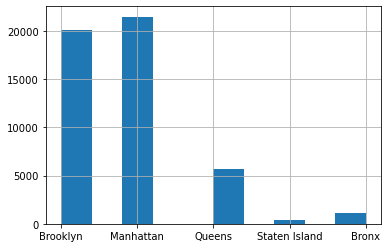

In [20]:
data['neighbourhood_group'].hist()

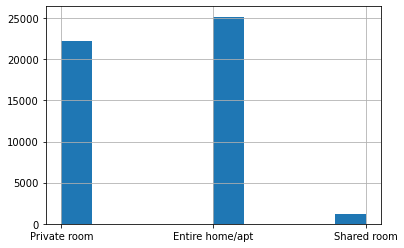

In [22]:
data['room_type'].hist()

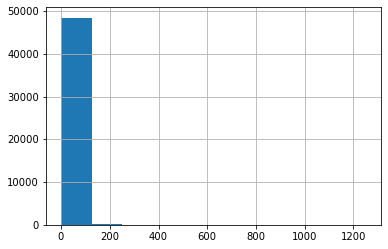

In [23]:
data['minimum_nights'].hist()

In [38]:
data[data['minimum_nights'] > 400].count()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

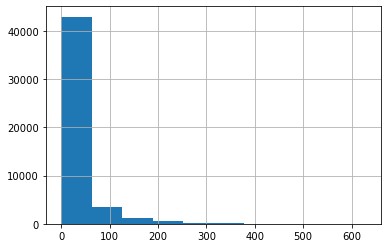

In [26]:
data['number_of_reviews'].hist()

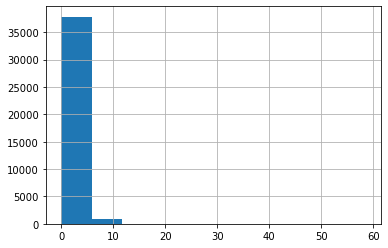

In [27]:
data['reviews_per_month'].hist()

In [33]:
data[data['reviews_per_month'] > 20].count(axis=1)

id
30423106    11
32678719    11
32678720    11
dtype: int64

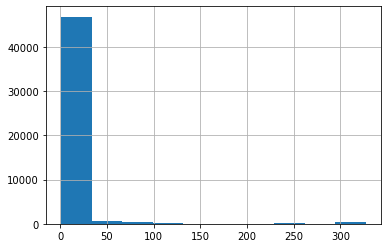

In [34]:
data['calculated_host_listings_count'].hist()

#### Видим значительную концентрацию записей в районе значений 250 и 300, пока не будем их удалять

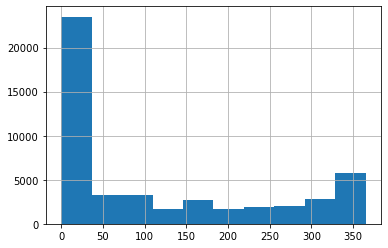

In [35]:
data['availability_365'].hist()

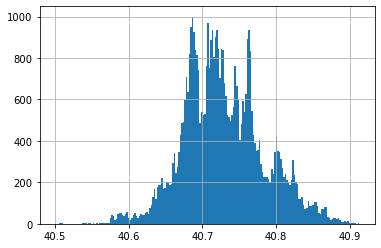

In [7]:
data['latitude'].hist(bins=200)

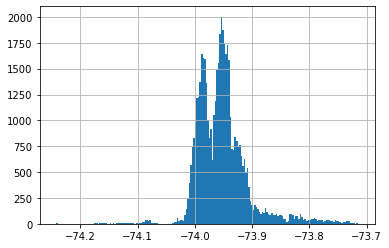

In [8]:
data['longitude'].hist(bins=200)

#### Распределения данных о координатах выглядят как нормальные с 3 и 2 смесями соответственно.

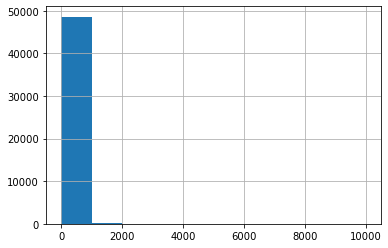

In [9]:
data['price'].hist()

In [10]:
data[data['price'] > 1000].count()

neighbourhood_group               239
neighbourhood                     239
latitude                          239
longitude                         239
room_type                         239
price                             239
minimum_nights                    239
number_of_reviews                 239
reviews_per_month                 107
calculated_host_listings_count    239
availability_365                  239
dtype: int64

#### Варианты с нулевой ценой стоимости аренды - скорее всего ошибка заполнения, уберем эти данные, также уберем единичные выбросы 

#### Цена больше 1000 встречается 239 раз, что для имеющейся выборки достаточно мало, попробуем исключить их

In [15]:
mask = (data['price'] < 1000) & (data['price'] != 0)

In [16]:
data = data[mask]

In [55]:
neighbourhoods_names = data.neighbourhood_group.unique()

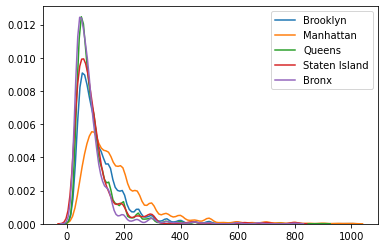

In [56]:
for neighbourhood in neighbourhoods_names:
    sns.kdeplot(data[data['neighbourhood_group'] == neighbourhood]['price'], label = neighbourhood);

In [60]:
room_types = data.room_type.unique()

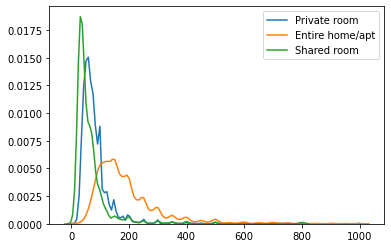

In [61]:
for room_type in room_types:
    sns.kdeplot(data[data['room_type'] == room_type]['price'], label = room_type);

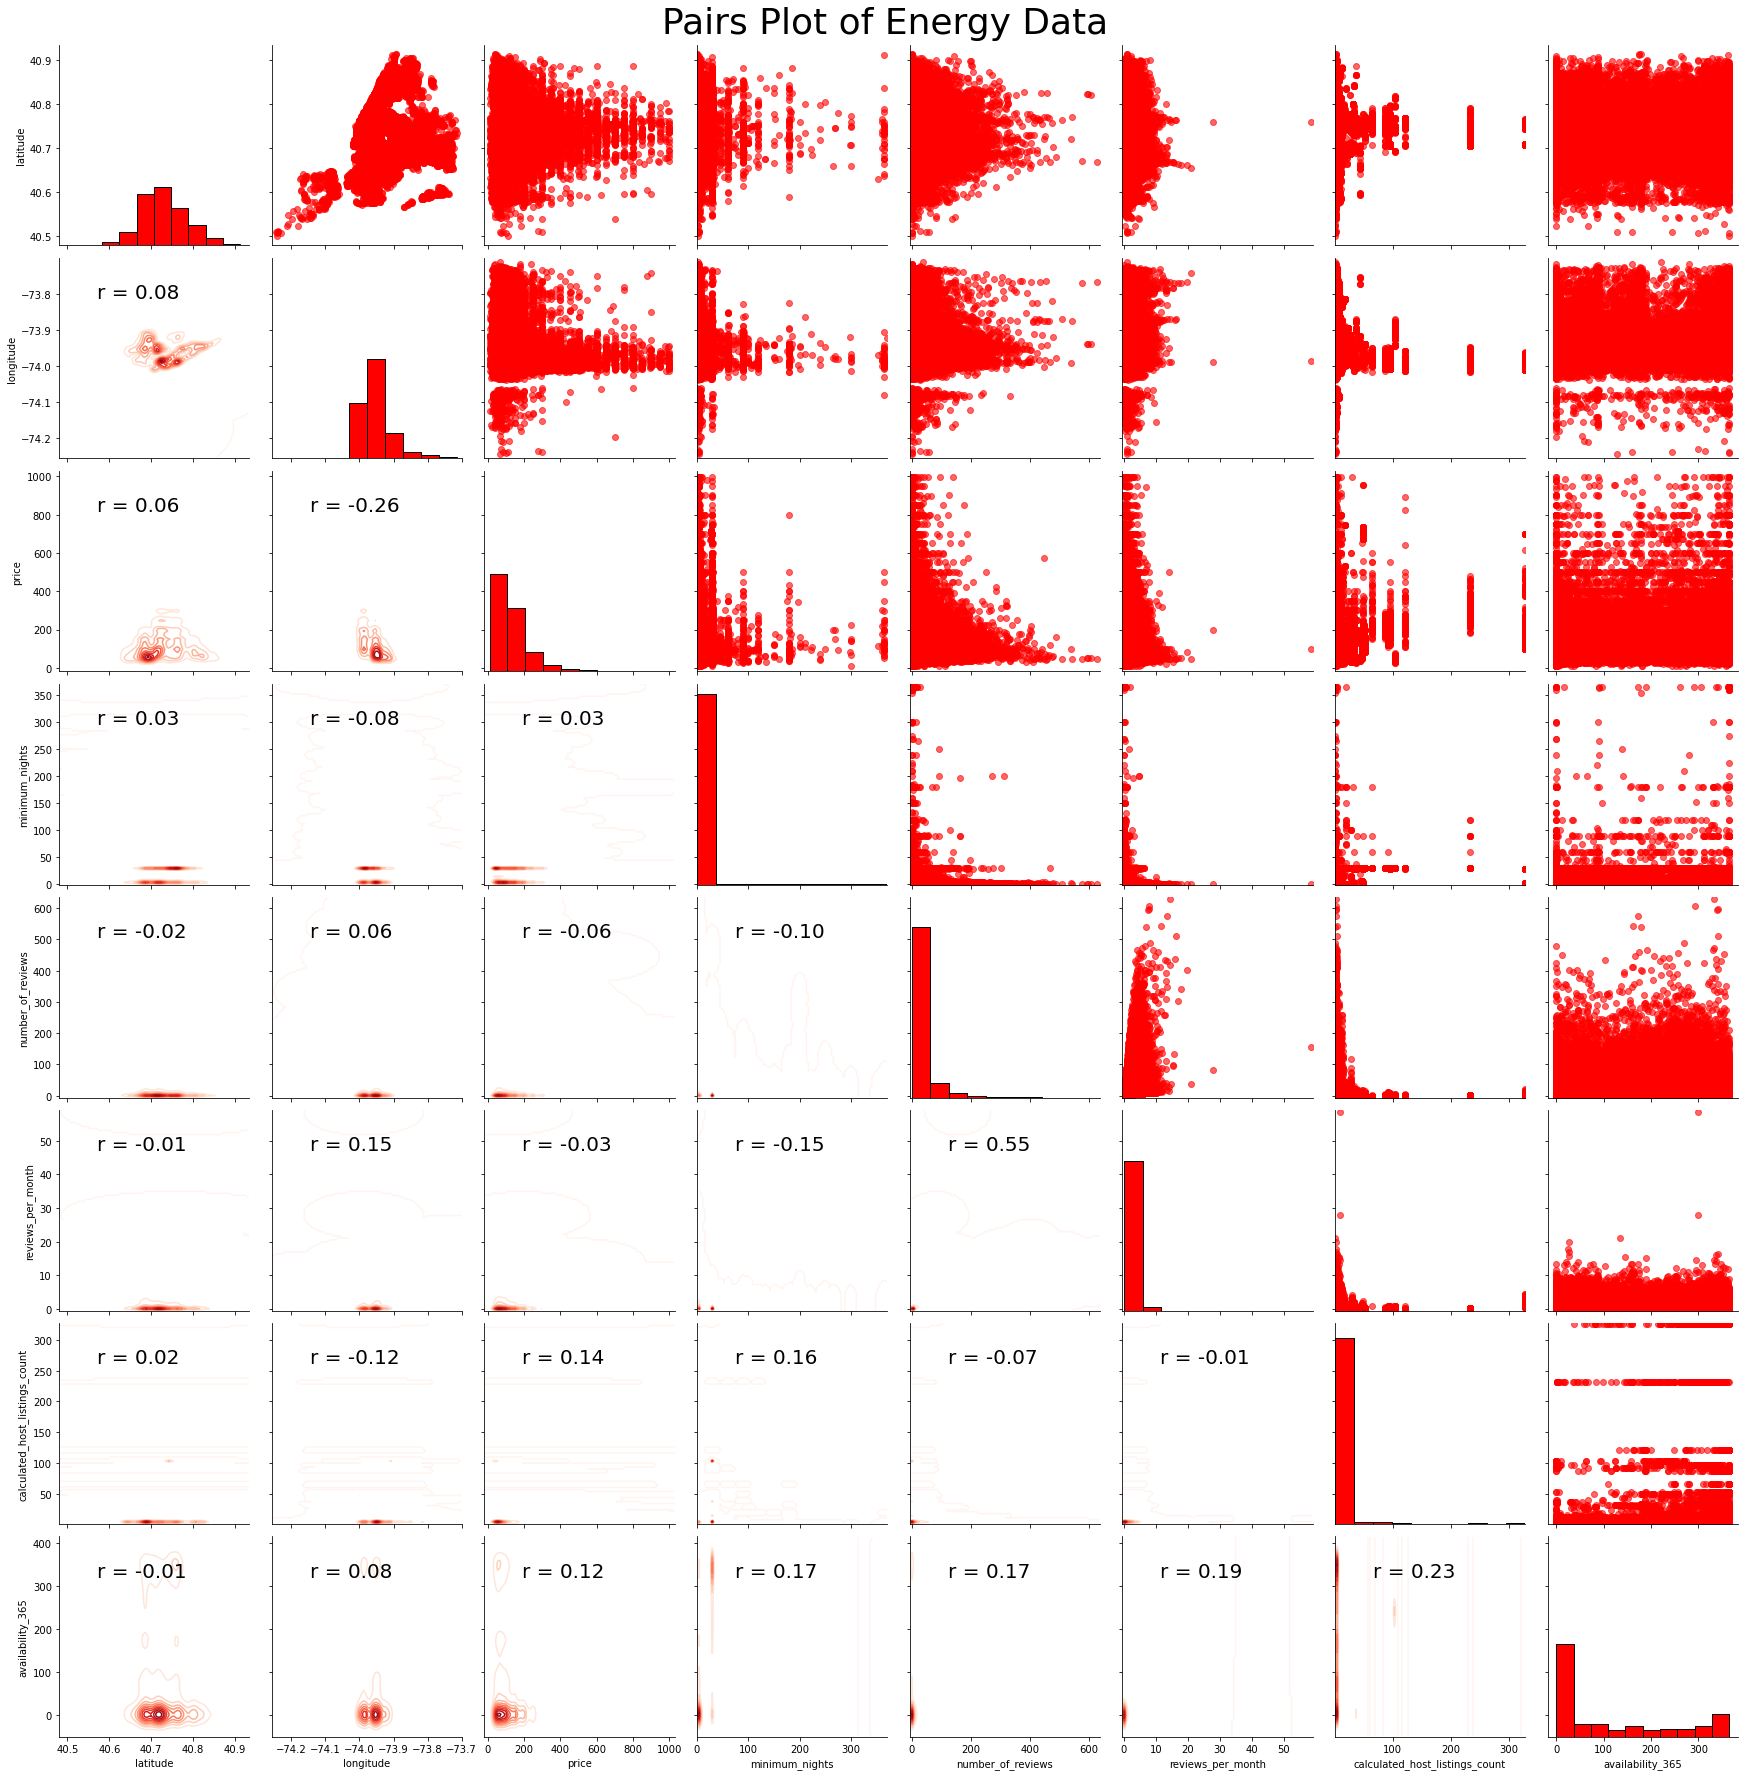

In [63]:
# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data=data, height=3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color='red', alpha=0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color='red', edgecolor='black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap=plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of AirBnB Data', size = 36, y = 1.02);

In [67]:
data.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.084654,0.063676,0.030121,-0.015312,-0.009881,0.019520,-0.010960
longitude,0.084654,1.000000,-0.264512,-0.075398,0.058137,0.145537,-0.115551,0.084961
price,0.063676,-0.264512,1.000000,0.025324,-0.056781,-0.030081,0.136629,0.117673
minimum_nights,0.030121,-0.075398,0.025324,1.000000,-0.095430,-0.145990,0.163192,0.165255
number_of_reviews,-0.015312,0.058137,-0.056781,-0.095430,1.000000,0.549718,-0.072740,0.173954
reviews_per_month,-0.009881,0.145537,-0.030081,-0.145990,0.549718,1.000000,-0.009532,0.187645
calculated_host_listings_count,0.019520,-0.115551,0.136629,0.163192,-0.072740,-0.009532,1.000000,0.227214
availability_365,-0.010960,0.084961,0.117673,0.165255,0.173954,0.187645,0.227214,1.000000


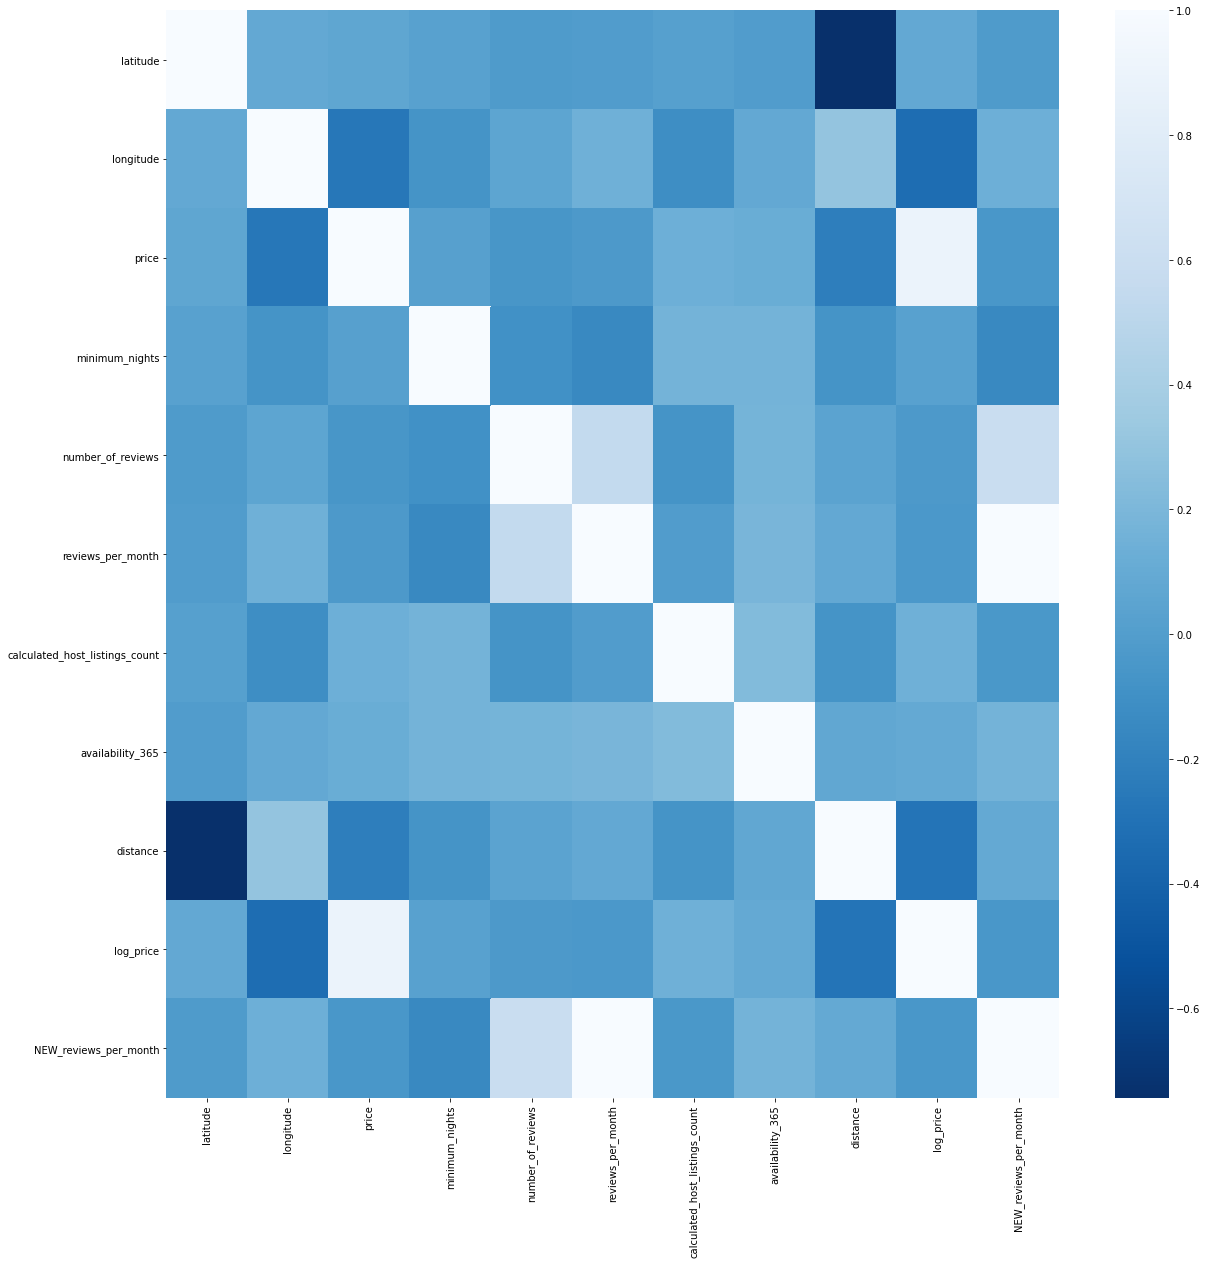

In [189]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), cmap='Blues_r')
plt.show()

## Preprocessing & Feature Engineering

### Попробуем прологарифмировать столбец цен

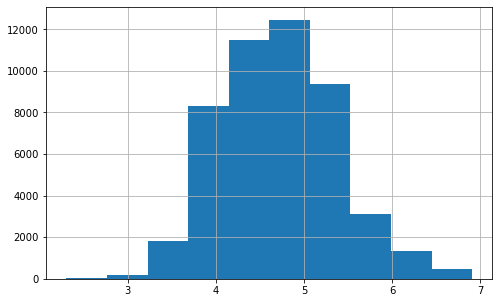

In [186]:
data['price'].apply(np.log).hist(figsize=(8,5))

### Похоже, что данные распределены логнормально

In [187]:
data['log_price'] = data['price'].apply(np.log)

### Добавим признак - расстояние до центра Манхеттана

In [70]:
NY_LAT = 40.78343 
NY_LONG = -73.96625

In [79]:
# Расчет расстояния между двумя точками на сфере (в километрах)
def get_distance(point_1: tuple, point_2: tuple) -> float:
    lat_1 = np.radians(point_1[0])
    long_1 = np.radians(point_1[1])
    
    lat_2 = np.radians(point_2[0])
    long_2 = np.radians(point_2[1])
    
    dlon = long_2 - long_1
    dlat = lat_2 - lat_1
    a = np.sin(dlat / 2)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

In [91]:
data['distance'] = data.apply(lambda x: get_distance((NY_LAT, NY_LONG), (x['latitude'], x['longitude'])), axis=1)

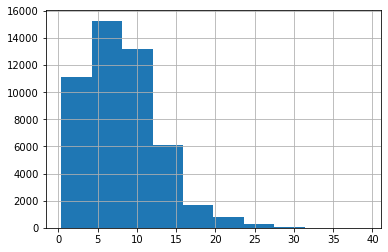

In [93]:
data['distance'].hist()

In [132]:
data[['price', 'log_price']].tail()

,price,log_price
id,,
36484665,70,4.248495
36485057,40,3.688879
36485431,115,4.744932
36485609,55,4.007333
36487245,90,4.499810


#### Посмотрим как распределены цены в зависимости от расстояния, также отметим цветом и метками различные значения районов и типов комнат

In [126]:
plt.rcParams["figure.figsize"] = [15, 10]

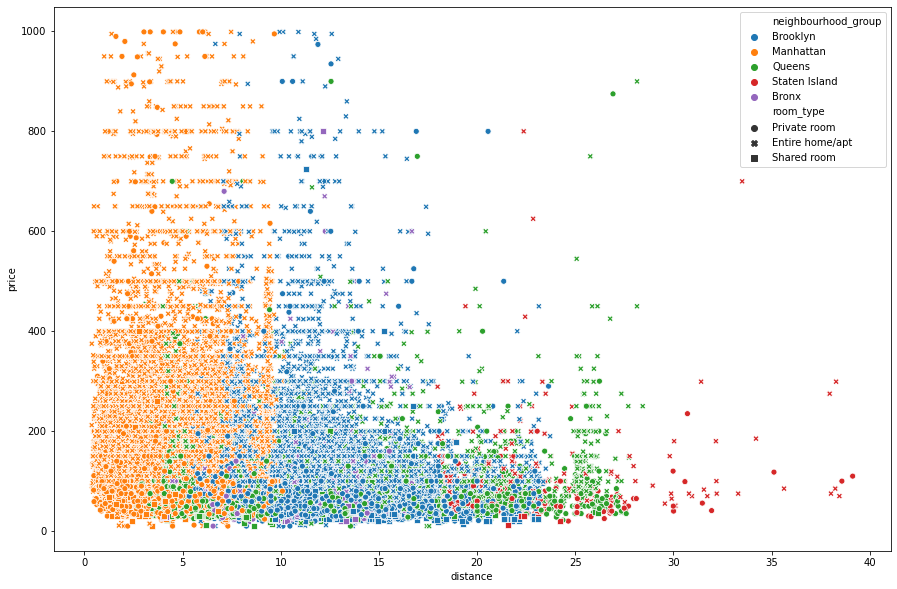

In [127]:
sns.scatterplot(data=data, x='distance', y='price', hue='neighbourhood_group', style='room_type')

### Посмотрим на столбцы - 'number_of_reviews', 'reviews_per_month'. Кажется, они должны быть как-то связаны

In [168]:
data[['number_of_reviews', 'reviews_per_month']]

,number_of_reviews,reviews_per_month
id,,
2539,9,0.21
2595,45,0.38
3647,0,NaN
3831,270,4.64
5022,9,0.10
...,...,...
36484665,0,NaN
36485057,0,NaN
36485431,0,NaN


### Проставим значение 0 в reviews_per_month везде где общее число ревью - 0

In [165]:
data['NEW_reviews_per_month'] = data.apply(lambda x: 0 if x['number_of_reviews'] == 0 and np.isnan(x['reviews_per_month']) else x['reviews_per_month'], axis=1)

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48574 entries, 2539 to 36487245
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48574 non-null  object 
 1   neighbourhood                   48574 non-null  object 
 2   latitude                        48574 non-null  float64
 3   longitude                       48574 non-null  float64
 4   room_type                       48574 non-null  object 
 5   price                           48574 non-null  int64  
 6   minimum_nights                  48574 non-null  int64  
 7   number_of_reviews               48574 non-null  int64  
 8   reviews_per_month               38691 non-null  float64
 9   calculated_host_listings_count  48574 non-null  int64  
 10  availability_365                48574 non-null  int64  
 11  distance                        48574 non-null  float64
 12  log_price                 

### Теперь значение частоты ревью присутствует во всех записях

In [191]:
data

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance,log_price,NEW_reviews_per_month
id,,,,,,,,,,,,,,
2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,15.124636,5.003946,0.21
2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,3.628259,5.416100,0.38
3647,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365,3.506884,5.010635,0.00
3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,10.943021,4.488636,4.64
5022,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2.514653,4.382027,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36484665,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,2,9,11.744931,4.248495,0.00
36485057,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36,9.490787,3.688879,0.00
36485431,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27,3.783977,4.744932,0.00


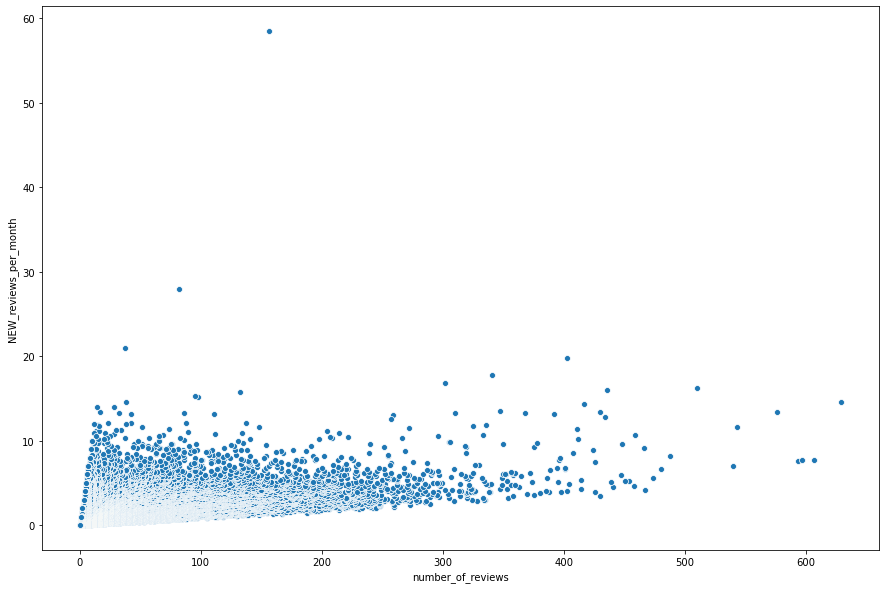

In [170]:
sns.scatterplot(data=data, x='number_of_reviews', y='NEW_reviews_per_month')

### Исключим аномальные значения:

In [ ]:
data = data[data['minimum_nights'] < 400]

In [ ]:
data = data[data['reviews_per_month'] < 20]

In [196]:
data

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance,log_price,NEW_reviews_per_month
id,,,,,,,,,,,,,,
2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,15.124636,5.003946,0.21
2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,3.628259,5.416100,0.38
3647,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365,3.506884,5.010635,0.00
3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,10.943021,4.488636,4.64
5022,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2.514653,4.382027,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36484665,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,2,9,11.744931,4.248495,0.00
36485057,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36,9.490787,3.688879,0.00
36485431,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27,3.783977,4.744932,0.00


In [209]:
data = data.drop(columns=['latitude', 'longitude', 'price', 'reviews_per_month'], axis=1)

KeyError: "['latitude' 'longitude' 'price' 'reviews_per_month'] not found in axis"

### Преобразуем категориальные признаки

#### попробуем начать c dummy

In [204]:
dummy_data = pd.get_dummies(data_clean, drop_first=True)

In [205]:
dummy_data.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,distance,log_price,NEW_reviews_per_month,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,,,,,,,
2539,1,9,6,365,15.124636,5.003946,0.21,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2595,1,45,2,355,3.628259,5.416100,0.38,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3647,3,0,1,365,3.506884,5.010635,0.00,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3831,1,270,1,194,10.943021,4.488636,4.64,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5022,10,9,1,0,2.514653,4.382027,0.10,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Modeling

In [206]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics  # подгружаем метрики

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats


measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [241]:
def show_reuslts(target_name: str):
    pass

### Baseline

#### Чтобы было с чем сравнивать посмотрим насколько хорошо данные описывает простая медиана

In [210]:
X_train, X_test, y_train, y_test = train_test_split(
    dummy_data.drop(['log_price'], axis=1), 
    dummy_data['log_price'], 
    test_size=0.3
)

In [211]:
y_median = np.median(y_train)                   
y_pred_naive = np.ones(len(y_test)) * y_median  
y_pred_naive[:5]

array([4.65396035, 4.65396035, 4.65396035, 4.65396035, 4.65396035])

In [212]:
measured_metrics['naive_baseline'] = dataframe_metrics(y_test, y_pred_naive)

In [213]:
measured_metrics

,error_type,naive_baseline
0,MAE,0.535092
1,RMSE,0.664286
2,R2,-0.008333
3,MAPE,11.486394


## Linear models

In [214]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[X_train.columns] = scaler.fit_transform(X_train)
X_test_scaled[X_train.columns] = scaler.transform(X_test)

In [215]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [216]:
measured_metrics['lr'] = dataframe_metrics(y_test, lr.predict(X_test_scaled))

In [221]:
lasso_cv = LassoCV()
lasso_cv.fit(X_train_scaled, y_train)
measured_metrics['lasso_cv'] = dataframe_metrics(y_test, lasso_cv.predict(X_test_scaled))

In [224]:
ridge_cv = RidgeCV()
ridge_cv.fit(X_train_scaled, y_train)
measured_metrics['ridge_cv'] = dataframe_metrics(y_test, ridge_cv.predict(X_test_scaled))

In [225]:
elastic_cv = ElasticNetCV()
elastic_cv.fit(X_train_scaled, y_train)
measured_metrics['elastic_cv'] = dataframe_metrics(y_test, elastic_cv.predict(X_test_scaled))


In [230]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
measured_metrics['rf'] = dataframe_metrics(y_test, rf.predict(X_test))

In [231]:
params = {
    'n_estimators':[10, 50, 100],
    'max_depth':[1, 2, 5, 7, 10],
    'max_features':[
        'auto', 
        X_train.shape[1]//2, 
        'sqrt',
        'log2'
    ]
}

rscv = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions = params,
    n_jobs=-1,
    verbose=1
)

In [235]:
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.9s finished


RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 5, 7, 10],
                                        'max_features': ['auto', 116, 'sqrt',
                                                         'log2'],
                                        'n_estimators': [10, 50, 100]},
                   verbose=1)

In [236]:
rscv.best_estimator_.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features=116, n_estimators=50)

In [237]:
measured_metrics['rf_cv'] = dataframe_metrics(y_test, rscv.best_estimator_.predict(X_test))

In [238]:
measured_metrics

,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.535092,9.226021e+08,0.326742,0.326555,0.326747,0.307149,0.324589
1,RMSE,0.664286,1.113753e+11,0.435567,0.435557,0.435570,0.416190,0.433832
2,R2,-0.008333,-2.834465e+22,0.566486,0.566506,0.566479,0.604199,0.569933
3,MAPE,11.486394,1.380188e+10,6.936978,6.931410,6.937108,6.521789,6.900356


## Рассмотрим подробнее лучший вариант - RandomForest, с MAE ~ 0.31

### Учитывая, что мы предсказыает логарифм цены, то в абсолютных числах ошибку можно вычислить так:
#### для нашего доверительного интервала справедливо
```
y_pred - предсказанное с помощью нашей модели значение
y_true - истинное значение цены для входных данных

ln(y_pred) - 0.31 < y_true < ln(y_pred) + 0.31
ln(y_pred) - 0.31 < ln(y_true) < ln(y_true) + 0.31
ln(y_pred) - 0.31 < ln(y_true) < ln(y_pred) + 0.31
ln(y_pred) - log(e^0.31) < ln(y_true) < ln(y_pred) + ln(e^0.31)
ln(y_pred/e^0.31) < ln(y_true) < ln(y_pred*e^0.31)

e^0.31 ~ 1.36

```
### Таким образом итоговая погрешность составила +- 36%